# Imports

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta

plt.style.use('seaborn-v0_8-muted') 
%matplotlib inline

# Data Preparation

In [102]:
def InfoExtraction(ticker, period='3y'):
    """
    Retrieves business information and historical data for Monte Carlo simulations.
    
    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'MSFT', 'GOOGL')
        period (str): Historical data period ('1y', '3y', '5y', 'max'). Default is '3y'
    
    Returns:
        dict: A dictionary containing company info and historical data for Monte Carlo simulations
    """
    stock = yf.Ticker(ticker)
        
    info = stock.info
        
    company_info = {
            'ticker': ticker.upper(),
            'company_name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'market_cap': info.get('marketCap', None),
            'currency': info.get('currency', 'USD'),
            'beta': info.get('beta', None),
            'pe_ratio': info.get('trailingPE', None),
            'current_price': info.get('currentPrice', None)
        }
        
    hist_data = stock.history(period=period)
        
    if hist_data.empty:
        raise Exception(f"No historical data found for ticker '{ticker}'")
        
    hist_data['Daily_Return'] = hist_data['Close'].pct_change()
    hist_data['Log_Return'] = np.log(hist_data['Close'] / hist_data['Close'].shift(1))
        
    hist_data_clean = hist_data.dropna()
        
    daily_mean_return = hist_data_clean['Daily_Return'].mean()
    daily_std_return = hist_data_clean['Daily_Return'].std()
    log_mean_return = hist_data_clean['Log_Return'].mean()
    log_std_return = hist_data_clean['Log_Return'].std()
        
        # Annualize statistics (252 trading days)
    trading_days = 252
    annual_mean_return = daily_mean_return * trading_days
    annual_std_return = daily_std_return * np.sqrt(trading_days)
        
    drift = log_mean_return + 0.5 * (log_std_return ** 2)
    annual_drift = drift * trading_days
        
    risk_free_rate = 0.0193

    monte_carlo_data = {
            'company_info': company_info,
            
            'historical_prices': hist_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy(),
            'historical_returns': hist_data_clean[['Daily_Return', 'Log_Return']].copy(),
            
            'monte_carlo_params': {
                'current_price': company_info['current_price'] or hist_data['Close'].iloc[-1],
                'daily_mean_return': daily_mean_return,
                'daily_std_return': daily_std_return,
                'log_mean_return': log_mean_return,
                'log_std_return': log_std_return,
                'annual_mean_return': annual_mean_return,
                'annual_std_return': annual_std_return,
                'drift': drift,
                'annual_drift': annual_drift,
                'volatility': annual_std_return,
                'trading_days_per_year': trading_days,
                'total_trading_days': len(hist_data_clean),
                'risk_free_rate': risk_free_rate,
                'beta': company_info['beta']
            },
            
           
        }
        
    return monte_carlo_data


In [103]:
data=InfoExtraction('SAN')

In [104]:
data

{'company_info': {'ticker': 'SAN',
  'company_name': 'Banco Santander, S.A.',
  'sector': 'Financial Services',
  'industry': 'Banks - Diversified',
  'market_cap': 187210088448,
  'currency': 'USD',
  'beta': 0.974,
  'pe_ratio': 12.66,
  'current_price': 12.66},
 'historical_prices':                                 Open       High        Low      Close   Volume
 Date                                                                          
 2023-01-30 00:00:00-05:00   3.108522   3.126595   3.081413   3.081413  4342000
 2023-01-31 00:00:00-05:00   3.117559   3.126595   3.090450   3.117559  3392500
 2023-02-01 00:00:00-05:00   3.198886   3.207922   3.117558   3.171777  7371900
 2023-02-02 00:00:00-05:00   3.388650   3.397687   3.271177   3.370578  9790700
 2023-02-03 00:00:00-05:00   3.388651   3.415760   3.334432   3.352505  8822700
 ...                              ...        ...        ...        ...      ...
 2026-01-22 00:00:00-05:00  12.310000  12.480000  12.230000  12.430000  34

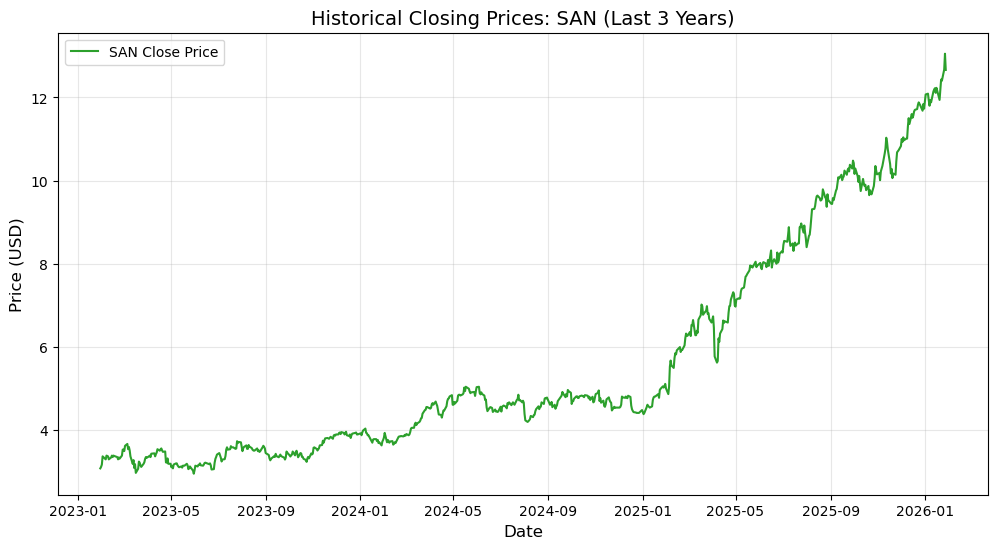

In [105]:
ticker = data['company_info']['ticker']
hist_df = data['historical_prices']

plt.figure(figsize=(12, 6))
plt.plot(hist_df.index, hist_df['Close'], label=f'{ticker} Close Price', color='#2ca02c')

plt.title(f'Historical Closing Prices: {ticker} (Last 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

# Variance Calculation

In [106]:
params = data['monte_carlo_params']
volatility = params['annual_std_return']
annual_variance = volatility ** 2

print(f"Ticker: {data['company_info']['ticker']}")
print(f"Annual Volatility (Sigma): {volatility:.4%}")
print(f"Annual Variance (Sigma^2): {annual_variance:.4%}")

Ticker: SAN
Annual Volatility (Sigma): 30.3329%
Annual Variance (Sigma^2): 9.2009%


# Running Simulation

In [107]:
def run_monte_carlo(data, num_simulations=10000, days_to_expiry=90):

    S0 = data['monte_carlo_params']['current_price']
    sigma = data['monte_carlo_params']['volatility']
    

    r = data['monte_carlo_params']['risk_free_rate']
    dt = 1 / 252 
    
    z = np.random.standard_normal((days_to_expiry, num_simulations))
    
    price_paths = np.zeros((days_to_expiry + 1, num_simulations))
    price_paths[0] = S0
    
    for t in range(1, days_to_expiry + 1):
        price_paths[t] = price_paths[t-1] * np.exp(
            (r - 0.5 * sigma**2) * dt + (sigma * np.sqrt(dt) * z[t-1])
        )
        
    return price_paths


sim_results = run_monte_carlo(data, num_simulations=10000, days_to_expiry=90)
print(f"Simulation complete. Shape of results: {sim_results.shape}")

Simulation complete. Shape of results: (91, 10000)


In [108]:
price_paths = sim_results 

simulation_df = pd.DataFrame(price_paths)
simulation_df.index.name = 'Day'
simulation_df.columns = [f'Sim_{i}' for i in range(simulation_df.shape[1])]

simulation_df

,Sim_0,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,...,Sim_9990,Sim_9991,Sim_9992,Sim_9993,Sim_9994,Sim_9995,Sim_9996,Sim_9997,Sim_9998,Sim_9999
Day,,,,,,,,,,,,,,,,,,,,,
0,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,...,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000,12.660000
1,12.607295,12.400960,12.752040,12.567717,12.625950,12.757753,12.139149,12.597264,12.411043,12.629598,...,12.553217,12.775917,12.509666,12.823726,12.465597,12.465623,12.718300,12.493632,12.426173,12.535209
2,12.548853,12.567055,12.769274,12.845757,12.729286,12.736135,12.005870,12.782767,12.254980,12.496008,...,12.332722,12.507699,12.318436,13.067327,12.418780,12.526187,13.159579,12.740073,12.764682,12.089336
3,12.670914,12.947989,12.750798,12.742105,12.461090,12.777886,12.330150,12.926870,12.110716,12.409789,...,12.321458,12.987969,12.252997,12.953865,12.195993,12.788907,12.979936,13.056354,12.533166,12.006536
4,13.029331,13.269419,12.910102,12.954217,11.939152,12.805747,12.246716,12.507408,12.391732,12.428262,...,12.132026,12.818741,12.225729,12.505482,11.791594,12.432609,12.777313,12.532128,12.446667,12.210663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,11.870425,10.847237,16.757255,13.443788,12.486363,9.917925,14.673902,13.171041,13.566644,12.639050,...,8.334343,10.783977,11.866503,11.898456,12.176469,12.197564,13.618251,9.959934,15.452033,9.631284
87,11.634113,10.824336,16.818395,14.023537,12.219580,9.802804,14.637785,12.817834,13.166682,12.505728,...,8.527612,11.061106,11.733393,11.625752,12.268952,12.347350,13.323449,10.118934,15.736219,9.512659
88,11.553701,11.350437,16.903486,13.950874,12.234097,10.107093,14.525663,12.801376,13.223817,12.441225,...,8.384338,10.739584,11.309780,11.604249,12.370287,12.034680,12.991519,9.985473,15.886538,9.604999


# Calculating Option Price (Call and Put)

In [118]:
def calculate_option_price(price_paths, strike_price, risk_free_rate, days_to_expiry):
    """
    Calculates the price of a European Call and Put option.
    """
    final_prices = price_paths[-1, :] 

    
    call_payoffs = np.maximum(final_prices - strike_price, 0)
    put_payoffs = np.maximum(strike_price - final_prices, 0)
    
    average_call_payoff = np.mean(call_payoffs)
    average_put_payoff = np.mean(put_payoffs)
    
    t_years = days_to_expiry / 365
    call_price = average_call_payoff * np.exp(-risk_free_rate * t_years)
    put_price = average_put_payoff * np.exp(-risk_free_rate * t_years)
    
    return call_price, put_price

current_price = data['monte_carlo_params']['current_price']
strike = current_price * 1.05  
r_free = data['monte_carlo_params']['risk_free_rate'] 

c_price, p_price = calculate_option_price(price_paths, strike, r_free, 90)

print(f"Current Stock Price: ${current_price:.2f}")
print(f"Strike Price: ${strike:.2f}")
print(f"--- Monte Carlo Results ---")
print(f"Estimated Call Option Price: ${c_price:.2f}")
print(f"Estimated Put Option Price: ${p_price:.2f}")

Current Stock Price: $12.66
Strike Price: $13.29
--- Monte Carlo Results ---
Estimated Call Option Price: $0.69
Estimated Put Option Price: $1.24


# Black Scholes Comparison Verification

In [110]:
def black_scholes_compare(S, K, T, r, sigma):
    """
    Calculates the theoretical Black-Scholes price for a European Call.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    bs_call = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return bs_call


r_free = data['monte_carlo_params']['risk_free_rate']
S0 = data['monte_carlo_params']['current_price']
K = S0 * 1.05
T_years = 90 / 252
vol = data['monte_carlo_params']['volatility']


bs_price = black_scholes_compare(S0, K, T_years, r_free, vol)
mc_price = c_price


print(f"Theoretical Black-Scholes Price: ${bs_price:.4f}")
print(f"Monte Carlo Estimated Price:    ${mc_price:.4f}")
print(f"Absolute Difference:           ${abs(bs_price - mc_price):.4f}")
print(f"Percentage Error:              {abs(bs_price - mc_price)/bs_price:.2%}")

Theoretical Black-Scholes Price: $0.6878
Monte Carlo Estimated Price:    $0.6874
Absolute Difference:           $0.0004
Percentage Error:              0.06%


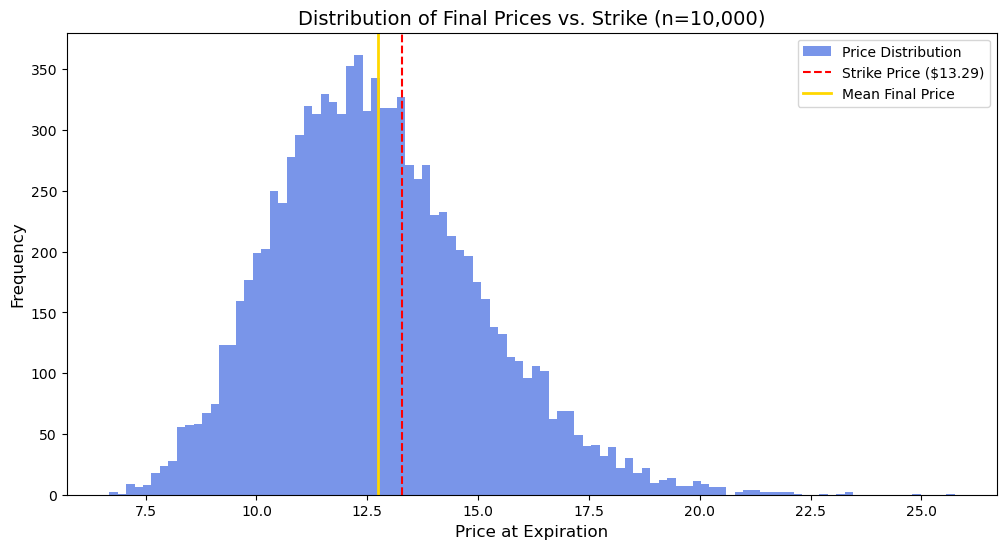

Probability of expiring In-The-Money: 37.12%


In [119]:
final_prices = sim_results[-1, :]

plt.figure(figsize=(12, 6))
plt.hist(final_prices, bins=100, color='royalblue', alpha=0.7, label='Price Distribution')
plt.axvline(K, color='red', linestyle='--', label=f'Strike Price (${K:.2f})')
plt.axvline(final_prices.mean(), color='gold', lw=2, label='Mean Final Price')

plt.title(f"Distribution of Final Prices vs. Strike (n=10,000)", fontsize=14)
plt.xlabel("Price at Expiration", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

itm_count = np.sum(final_prices > K)
print(f"Probability of expiring In-The-Money: {itm_count/10000:.2%}")

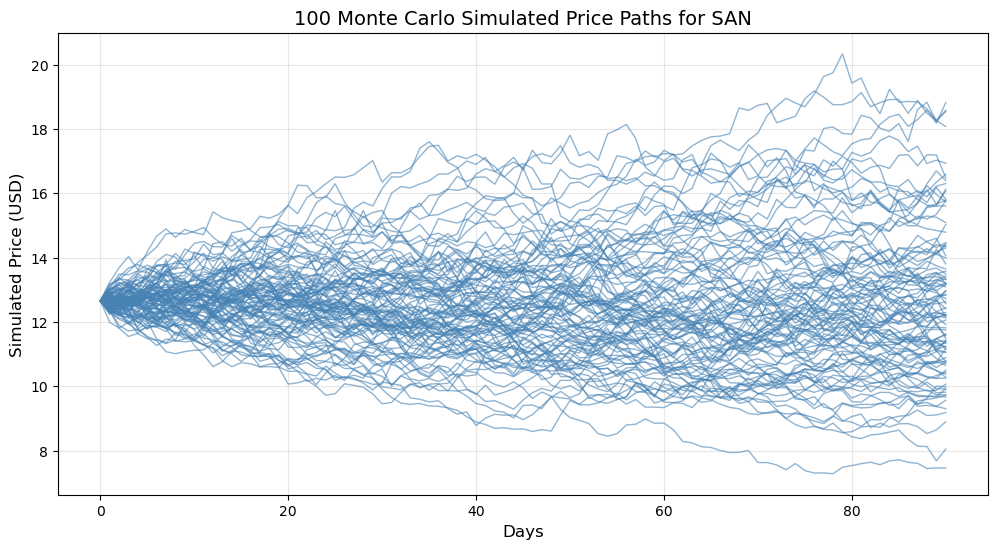

In [115]:
np.random.seed(42)
num_to_plot = 100
selected_indices = np.random.choice(sim_results.shape[1], num_to_plot, replace=False)

selected_paths = sim_results[:, selected_indices]

plt.figure(figsize=(12, 6))

for i in range(num_to_plot):
    plt.plot(selected_paths[:, i], color='steelblue', alpha=0.6, lw=1)

plt.title(f'100 Monte Carlo Simulated Price Paths for {data["company_info"]["ticker"]}', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Simulated Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Sensitivity Analysis

In [116]:
def estimate_greeks(data, strike, days_to_expiry, num_sims=50000):
    S0 = data['monte_carlo_params']['current_price']
    sigma = data['monte_carlo_params']['volatility']
    r = data['monte_carlo_params']['risk_free_rate']
    
    ds = S0 * 0.01
    dv = 0.01
    
    def get_price(S_bump, sigma_bump):
        temp_data = data.copy()
        temp_data['monte_carlo_params'] = data['monte_carlo_params'].copy()
        temp_data['monte_carlo_params']['current_price'] = S_bump
        temp_data['monte_carlo_params']['volatility'] = sigma_bump
        
        paths = run_monte_carlo(temp_data, num_simulations=num_sims, days_to_expiry=days_to_expiry)
        c_price, _ = calculate_option_price(paths, strike, r, days_to_expiry)
        return c_price

    print("Calculating Greeks... (this may take a few seconds)")
    price_up   = get_price(S0 + ds, sigma)
    price_down = get_price(S0 - ds, sigma)
    price_base = get_price(S0, sigma)
    price_vol_up = get_price(S0, sigma + dv)
    
    delta = (price_up - price_down) / (2 * ds)
    
    vega_impact = price_vol_up - price_base
    
    return delta, vega_impact, price_base

delta_mc, vega_mc, current_val = estimate_greeks(data, strike, 90)

print(f"\n--- Greeks Approximation (Monte Carlo) ---")
print(f"Option Delta: {delta_mc:.4f}")
print(f"Volatility Impact (1% move): ${vega_mc:.4f}")
print(f"Current Option Value: ${current_val:.2f}")

Calculating Greeks... (this may take a few seconds)

--- Greeks Approximation (Monte Carlo) ---
Option Delta: 0.4179
Volatility Impact (1% move): $0.0319
Current Option Value: $0.69
